In [1]:
# Install Kaggle API
!pip install -q kaggle

# Upload kaggle.json
# from google.colab import files
# files.upload()

# Create Kaggle folder and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d siddharthkumarsah/ships-in-aerial-images

# Unzip the dataset
!unzip ships-in-aerial-images.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/ships-aerial-images/train/labels/x0593_png.rf.33fd03bd0d9896e31b73ac56c1e458c8.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0594_png.rf.1a86349573567a368a653b5b39fff4af.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0594_png.rf.ff6551627101ade7c4ecd6887fa45546.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0595_png.rf.bc03f4a3bc686c5d239d8552ce57b5f5.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0597_png.rf.918ed233995c3645a1ca8d14bf35a81c.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0598_png.rf.94d8be92f98bf3ff36cf9f51b1e17bc9.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0598_png.rf.a5b224c7880ba832c9d6d5aba3123e28.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0599_png.rf.d215436f7b245cf0a244ab1c79118c83.txt  
  inflating: dataset/ships-aerial-images/train/labels/x0600_png.rf.6d245857b874aeb58d67bfee5f0d8837.t

In [2]:
import os
import json
import cv2


#Convert Dataset to COCO Format
#Category mapping

categories = [
    {"id": 1, "name": "ship"}
]

def create_coco_annotation(ann_id, image_id, width, height, annotations):
    coco_annotations = []
    for ann in annotations:
        coco_annotation = {
            "id": ann_id,
            "image_id": image_id,
            "category_id": ann['category_id'],
            "bbox": ann['bbox'],
            "area": ann['bbox'][2] * ann['bbox'][3],
            "iscrowd": 0
        }
        coco_annotations.append(coco_annotation)
        ann_id += 1
    return coco_annotations, ann_id

def create_coco_image(image_id, file_name, width, height):
    return {
        "id": image_id,
        "file_name": file_name,
        "width": width,
        "height": height
    }

# Function to process a single dataset (train, valid,  test)
def convert_dataset_to_coco(dataset_path):
    images_path = os.path.join(dataset_path, "images")
    annotations_path = os.path.join(dataset_path, "labels")
    output_path = os.path.join(dataset_path, "annotations_coco")

    os.makedirs(output_path, exist_ok=True)

    images = []
    annotations = []
    annotation_id = 1

    for image_filename in os.listdir(images_path):
        if not image_filename.endswith(".jpg"):
            continue

        image_id = os.path.splitext(image_filename)[0]
        image_path = os.path.join(images_path, image_filename)
        annotation_path = os.path.join(annotations_path, f"{image_id}.txt")

        # Error handling for image loading
        try:
            image = cv2.imread(image_path)
            if image is None:  # Check if image loaded successfully
                print(f"Error loading image: {image_path}")
                continue
            height, width, _ = image.shape
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
            continue

        images.append(create_coco_image(image_id, image_filename, width, height))

        image_annotations = []
        if os.path.exists(annotation_path) and os.path.getsize(annotation_path) > 0:
            with open(annotation_path, "r") as file:
                for line in file:
                    parts = line.strip().split()
                    yolo_class_id = int(parts[0])
                    x_center = float(parts[1]) * width
                    y_center = float(parts[2]) * height
                    bbox_width = float(parts[3]) * width
                    bbox_height = float(parts[4]) * height

                    # Convert YOLO bbox format to COCO bbox format
                    x_min = x_center - bbox_width / 2
                    y_min = y_center - bbox_height / 2

                    image_annotations.append({
                        "category_id": yolo_class_id + 1,  # COCO category IDs are 1-based
                        "bbox": [x_min, y_min, bbox_width, bbox_height]
                    })

        if image_annotations:
            coco_image_annotations, annotation_id = create_coco_annotation(
                annotation_id, image_id, width, height, image_annotations
            )
            annotations.extend(coco_image_annotations)

    coco_format = {
        "images": images,
        "annotations": annotations,
        "categories": categories
    }

    output_json_path = os.path.join(output_path, "annotations_coco.json")
    with open(output_json_path, "w") as json_file:
        json.dump(coco_format, json_file, indent=4)

    print(f"COCO format annotations saved to {output_json_path}")


dataset_base_path = "/content/dataset/ships-aerial-images"
for dataset_type in ["train", "valid", "test"]:
  dataset_path = os.path.join(dataset_base_path, dataset_type)
  convert_dataset_to_coco(dataset_path)

COCO format annotations saved to /content/dataset/ships-aerial-images/train/annotations_coco/annotations_coco.json
COCO format annotations saved to /content/dataset/ships-aerial-images/valid/annotations_coco/annotations_coco.json
COCO format annotations saved to /content/dataset/ships-aerial-images/test/annotations_coco/annotations_coco.json


In [3]:
import os
import json
import torch
from PIL import Image
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

class ShipDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "images"))))

        # Load COCO annotations
        with open(os.path.join(root, "annotations_coco", "annotations_coco.json"), 'r') as f:
            self.coco_annotations = json.load(f)

        # Create a mapping from image ID to annotations
        self.img_id_to_annotations = {}
        for ann in self.coco_annotations["annotations"]:
            img_id = ann["image_id"]
            if img_id not in self.img_id_to_annotations:
                self.img_id_to_annotations[img_id] = []
            self.img_id_to_annotations[img_id].append(ann)

        # Create a mapping from image ID to image info
        self.img_id_to_info = {img["id"]: img for img in self.coco_annotations["images"]}

    def __getitem__(self, idx):
      img_filename = self.imgs[idx]
      img_id = os.path.splitext(img_filename)[0]

      if img_id not in self.img_id_to_annotations:
          return None, None

      img_info = self.img_id_to_info[img_id]
      img_path = os.path.join(self.root, "images", img_filename)

      try:
          img = Image.open(img_path).convert("RGB")
      except IOError:
          print(f"Error loading image: {img_path}")
          return None, None  # Return None for both image and target

      annotations = self.img_id_to_annotations[img_id]

      boxes = []
      labels = []

      for ann in annotations:
          labels.append(ann["category_id"])
          bbox = ann["bbox"]
          xmin = bbox[0]
          ymin = bbox[1]
          xmax = bbox[0] + bbox[2]
          ymax = bbox[1] + bbox[3]

          # Check if the bounding box has positive height and width
          if xmax > xmin and ymax > ymin:
              boxes.append([xmin, ymin, xmax, ymax])
          else:
              # Skip invalid bounding boxes
              continue

      if not boxes:
          # If no valid bounding boxes are found, return None
          return None, None

      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      labels = torch.as_tensor(labels, dtype=torch.int64)

      image_id = torch.tensor([idx])
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
      iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

      target = {
          "boxes": boxes,
          "labels": labels,
          "image_id": image_id,
          "area": area,
          "iscrowd": iscrowd
      }

      if self.transforms is not None:
          img = self.transforms(img)

      return img, target


    def __len__(self):
        return len(self.imgs)


def collate_fn(batch):
    return tuple(zip(*batch))

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):

    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    return model

# Our dataset has one class (ship) + background
num_classes = 2
model = get_model(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 49.2MB/s]


In [5]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
# Define transformations
transform = T.Compose([T.ToTensor()])

In [15]:



# Create the dataset and dataloader
dataset = ShipDataset("/content/dataset/ships-aerial-images/train", transforms=transform)
dataset_size = len(dataset)
subset_size = int(1 * dataset_size)  # 10% of the dataset
rest_size = dataset_size - subset_size
subset, _ = random_split(dataset, [subset_size, rest_size])
data_loader = DataLoader(subset, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Number of epochs
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for i, (images, targets) in enumerate(progress_bar):
        valid_indices = [i for i, t in enumerate(targets) if t is not None and t['boxes'].size(0) > 0]
        if len(valid_indices) == 0:
            continue  # Skip this batch if all targets are empty
        images = [images[i].to(device) for i in valid_indices]
        targets = [{k: v.to(device) for k, v in targets[i].items()} for i in valid_indices]
        # Forward pass
        loss_dict = model(images, targets)

        # Compute losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Update running loss
        running_loss += losses.item()

        # Update progress bar
        progress_bar.set_postfix(loss=running_loss/(i+1))

    # Update the learning rate
    lr_scheduler.step()

torch.save(model.state_dict(), 'ship_detection_model.pth')
print("Model saved to 'ship_detection_model.pth'")

print("Training complete!")

Epoch 1/1: 100%|██████████| 4849/4849 [31:46<00:00,  2.54batch/s, loss=0.295]


Model saved to 'ship_detection_model.pth'
Training complete!


In [28]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- 3. Evaluation Function ---
@torch.no_grad()
def evaluate(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    all_predictions = []
    ground_truth_data = []

    for images, targets in tqdm(data_loader, desc="Evaluating"):
        images = list(image.to(device) for image in images if image is not None)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets if t is not None]

        predictions = model(images)

        for i, prediction in enumerate(predictions):
            boxes = prediction['boxes'].detach().cpu().numpy()
            labels = prediction['labels'].detach().cpu().numpy()
            scores = prediction['scores'].detach().cpu().numpy()

            image_predictions = []
            for box, label, score in zip(boxes, labels, scores):
                image_predictions.append({
                    'bbox': box.tolist(),
                    'category_id': label,
                    'score': score
                })

            all_predictions.append({
                'image_id': targets[i]['image_id'].item(),
                'predictions': image_predictions
            })

            ground_truth_data.append({
                'image_id': targets[i]['image_id'].item(),
                'annotations': [{'bbox': bbox.tolist(), 'category_id': category_id}
                                for bbox, category_id in zip(targets[i]['boxes'].cpu().numpy(),
                                                            targets[i]['labels'].cpu().numpy())]
            })

    return all_predictions, ground_truth_data




# --- Settings ---
val_dataset_path = "/content/dataset/ships-aerial-images/valid"
model_path = 'ship_detection_model.pth'
batch_size = 4  #
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# --- Load Model ---
model = get_model(num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# --- Load Validation Data (10%) ---
val_dataset = ShipDataset(val_dataset_path, transforms=transform)
val_dataset_size = len(val_dataset)
val_subset_size = int(0.01 * val_dataset_size)
val_subset, _ = random_split(val_dataset, [val_subset_size, val_dataset_size - val_subset_size])
val_data_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

# --- Evaluate and Visualize ---
all_predictions, ground_truth_data = evaluate(model, val_data_loader, device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Evaluating: 100%|██████████| 6/6 [02:17<00:00, 22.92s/it]


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# --- 4. IoU Calculation ---
def calculate_iou(box1, box2):
  x1 = max(box1[0], box2[0])
  y1 = max(box1[1], box2[1])
  x2 = min(box1[2], box2[2])
  y2 = min(box1[3], box2[3])

  intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
  box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
  box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
  iou = intersection_area / float(box1_area + box2_area - intersection_area)
  return iou


# --- 6. mAP Calculation (Single Class) ---
def calculate_map(predictions, ground_truth, iou_threshold=0.5):
  all_gt_boxes = []
  for gt in ground_truth['annotations']:
      all_gt_boxes.append({
          'image_id': gt['image_id'],
          'bbox': gt['bbox'],
          'category_id': gt['category_id']
      })

  sorted_predictions = sorted(
      [p for pred in predictions for p in pred['predictions']],
      key=lambda x: x['score'],
      reverse=True
  )

  tp = np.zeros(len(sorted_predictions))
  fp = np.zeros(len(sorted_predictions))
  num_gt_boxes = len(all_gt_boxes)

  for i, prediction in enumerate(sorted_predictions):
      matched = False
      for j, gt_box in enumerate(all_gt_boxes):
          if prediction['image_id'] == gt_box['image_id'] and calculate_iou(prediction['bbox'], gt_box['bbox']) >= iou_threshold:
              matched = True
              all_gt_boxes.pop(j)
              break

      if matched:
          tp[i] = 1
      else:
          fp[i] = 1

  tp_cumulative = np.cumsum(tp)
  fp_cumulative = np.cumsum(fp)
  precision = tp_cumulative / (tp_cumulative + fp_cumulative + 1e-10)
  recall = tp_cumulative / (num_gt_boxes + 1e-10)

  ap = 0.0
  for i in range(len(recall) - 1):
      ap += (recall[i + 1] - recall[i]) * precision[i + 1]
  return ap


###### 7
# --- 2. Metrics Calculation ---
def calculate_metrics(predictions, ground_truth, iou_threshold=0.5):
    all_tps = 0
    all_fps = 0
    all_fns = 0
    true_labels = []
    pred_labels = []

    for gt in ground_truth:
        gt_boxes = gt['annotations']
        image_id = gt['image_id']

        pred_boxes = next((p['predictions'] for p in predictions if p['image_id'] == image_id), [])
        pred_boxes = sorted(pred_boxes, key=lambda x: x['score'], reverse=True)

        matched_gt = set()
        for pred in pred_boxes:
            pred_label = pred['category_id']
            pred_labels.append(pred_label)

            best_iou = 0
            best_gt_idx = None
            for gt_idx, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(pred['bbox'], gt_box['bbox'])
                if iou > best_iou and iou >= iou_threshold and gt_idx not in matched_gt:
                    best_iou = iou
                    best_gt_idx = gt_idx

            if best_gt_idx is not None:
                all_tps += 1
                matched_gt.add(best_gt_idx)
                true_labels.append(gt_boxes[best_gt_idx]['category_id'])
            else:
                all_fps += 1
                true_labels.append(0)

        all_fns += len(gt_boxes) - len(matched_gt)

    if all_tps + all_fps == 0:
        precision = 1.0 if all_fns == 0 else 0.0
    else:
        precision = all_tps / (all_tps + all_fps)

    if all_tps + all_fns == 0:
        recall = 1.0
    else:
        recall = all_tps / (all_tps + all_fns)

    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    conf_matrix = confusion_matrix(true_labels, pred_labels)
    return precision, recall, f1, conf_matrix


In [30]:
precision, recall, f1, conf_matrix = calculate_metrics(all_predictions, ground_truth_data)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", conf_matrix)

Precision: 0.0459
Recall: 0.5625
F1 Score: 0.0849
Confusion Matrix:
 [[  0 374]
 [  0  18]]


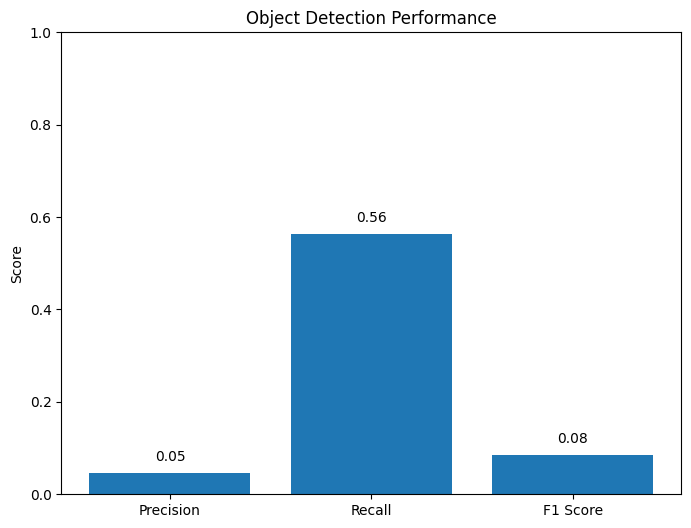

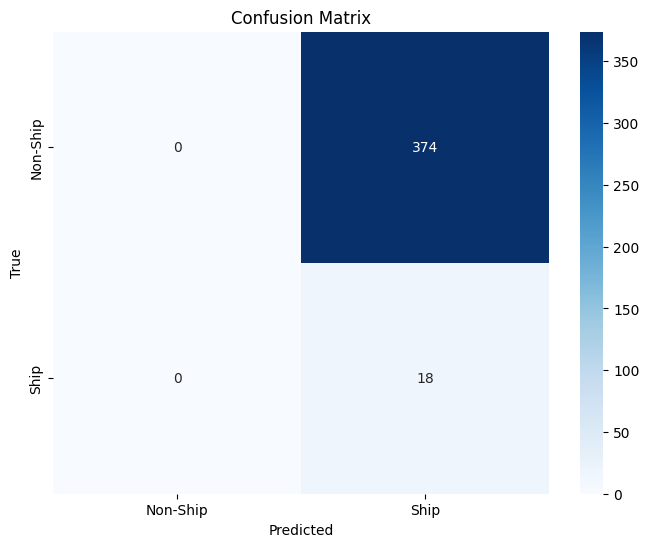

In [31]:
import seaborn as sns
#Precision, Recall, F1 Score
plt.figure(figsize=(8, 6))
plt.bar(['Precision', 'Recall', 'F1 Score'], [precision, recall, f1])
plt.ylim(0, 1.0)  # Set y-axis limits to 0-1
plt.title('Object Detection Performance')
plt.ylabel('Score')
for i, v in enumerate([precision, recall, f1]):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
plt.show()

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Ship', 'Ship'], yticklabels=['Non-Ship', 'Ship'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

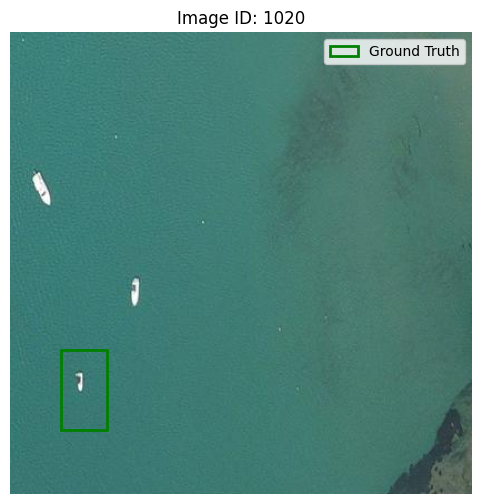

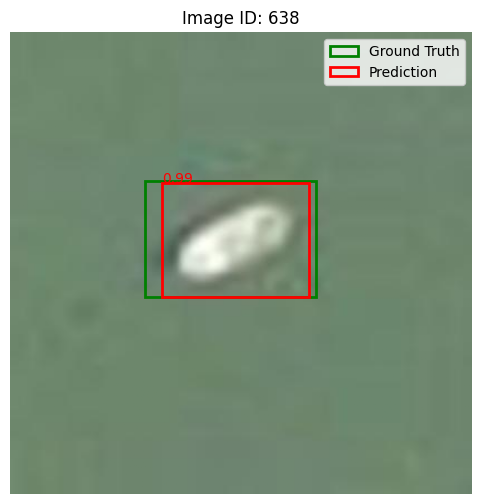

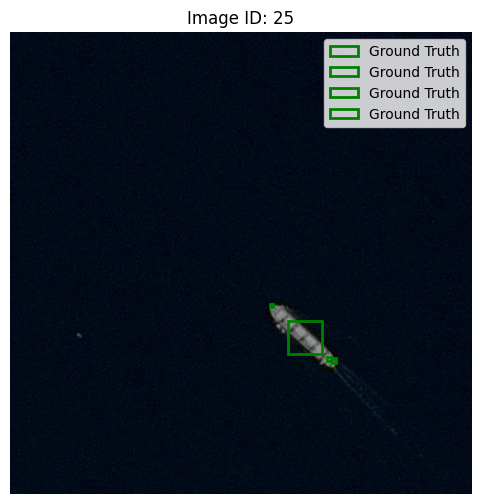

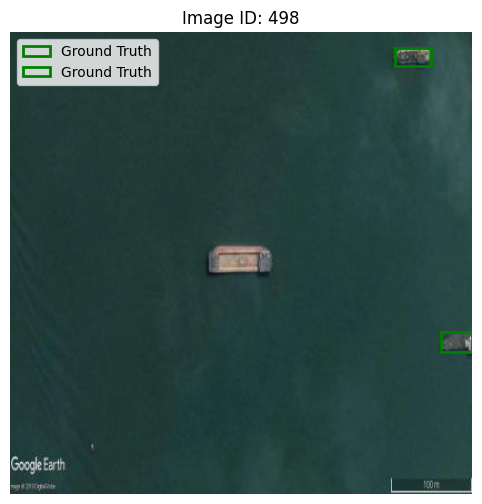

In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

def visualize_predictions(images, targets, predictions, num_images_to_visualize=10, score_threshold=0.6):
    """Visualizes ground truth and predicted bounding boxes on images.

    Args:
        images (list): List of images (tensors) from the data loader.
        targets (list): List of target dictionaries from the data loader.
        predictions (list): List of prediction dictionaries.
        num_images_to_visualize (int): Number of random images to visualize.
        score_threshold (float): Minimum confidence score for predictions to be displayed.
    """

    image_ids_to_visualize = random.sample(range(len(images)), min(num_images_to_visualize, len(images)))

    for image_idx in image_ids_to_visualize:
        image = images[image_idx].permute(1, 2, 0).cpu().numpy()  # Convert to NumPy array
        target = targets[image_idx]
        image_id = target['image_id'].item()

        # Get predictions for this image
        pred_boxes = next((p['predictions'] for p in predictions if p['image_id'] == image_id), [])

        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        ax = plt.gca()

        # Plot ground truth boxes
        for gt_box in target['boxes'].cpu().numpy():
            rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2] - gt_box[0], gt_box[3] - gt_box[1],
                                        linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
            ax.add_patch(rect)

        # Plot predicted boxes (with score threshold)
        for pred in pred_boxes:
            bbox = pred['bbox']
            score = pred['score']

            if score >= score_threshold:
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                            linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
                ax.add_patch(rect)
                plt.text(bbox[0], bbox[1], f'{score:.2f}', color='r')  # Add score as text

        plt.title(f'Image ID: {image_id}')
        plt.axis('off')  # Hide axes
        plt.legend()
        plt.show()

num_images_to_visualize = 5
score_threshold = 0.4  # threshold
visualize_predictions(images, targets, all_predictions, num_images_to_visualize, score_threshold)